# Weather Project by Stefano Chiesa

This project was made by **Chiesa Stefano**, as an assignment for *Python class*.
Resources used: Stackoverflow, ChatGPT, Python Lectures and Geopandas documentation.

**Original tasks**:
The dataset reports the temperature recorded in major cities around the world since 1750. Using this data, the project will need to provide an effective graphical visualization of the change in temperatures over time, highlighting the cities where the largest temperature ranges were recorded during different historical periods. For visualization of the data on a map, see geopandas.

The program will also suggest, depending on the period considered, the best route to follow for a traveler who intends to move from Beijing to Los Angeles by moving step by step to the warmest city among the 3 closest to him.

**Modifications**:
The program provides the best route between two given cities, not just between Beijing (Peking in the dataset) and Los Angeles. I also coded some functions during the testing of the Geopandas package that I kept in the final project.

## Files to be considered for the project:
- presentation.ipynb
- **utils.py**: a module for functions
- **cleaning.py**: a module for data cleaning
- **map.py**: a module containing the class Map, for OOP


## Data Cleaning
The provided had a problem with coordinates: 
_Eg. for coordinates (Latitude, Longitude): (5.63, 3.23)_

The main problem with this is that we will use the **Geopandas** package, that doesn't support this format. 
We need to convert the _"N"_ and the _"S"_ respectively in _"+"_ and _"-"_. Same with _"E"_ and _"W"_.
To fix this problem I have created the module **cleaning**, that contains the functions **convert** and **clean_data**.

In [1]:
def convert(db, column):
    if column == 'Latitude':
        for x in range(len(db[column].index)):
            if db.at[x, column][-1] == 'N':
                db.at[x, column] = '+' + db.at[x, column][0:len(db.at[x, column]) - 1]
            elif db.at[x, column][-1] == 'S':
                db.at[x, column] = '-' + db.at[x, column][0:len(db.at[x, column]) - 1]

    elif column == 'Longitude':
        for x in range(len(db[column].index)):
            if db.at[x, column][-1] == 'E':
                db.at[x, column] = '+' + db.at[x, column][0:len(db.at[x, column]) - 1]
            elif db.at[x, column][-1] == 'W':
                db.at[x, column] = '-' + db.at[x, column][0:len(db.at[x, column]) - 1]

    return db

The function **convert** changes the last value of the columns "Latitude" and "Longitude" with "+" and "-" symbols.

In [2]:
def clean_data(path):
    tem_dataframe = pd.read_csv(path, sep=',')

    # cleaning the data
    tfp_dataframe = tem_dataframe.drop(['AverageTemperatureUncertainty', 'Country'], axis=1)

    # run the functions to change the coordinates data
    tfp_dataframe = convert(tfp_dataframe, 'Latitude')
    tfp_dataframe = convert(tfp_dataframe, 'Longitude')
    # upload the modifications
    tfp_dataframe.to_csv('venv/data/data_cities.csv', index=False)
    return tfp_dataframe

Then the function *clean_data* actually does the conversion on the dataset, opening the connection and also dropping some columns we don't need for our tasks. 
Notice that this function calls *convert*, meaning that we don't need to call both of them separately: they work together.
I did this because I thought that it could be useful to have separate functions: maybe I will need to convert the pandas dataframe and not the dataset.
For the porpoise of the project, I just needed to call **clean_data** just one time, because I always worked with the same dataset.

## Preparing the basics parameters:
In this project the base of almost every function will be:
- A **geopandas dataframe** containing all the data: the data it's taken from the given dataset;
- A **geopandas dataset** containing the world map data: de data it's taken from a inbuilt geopandas' dataset (that we'll be deprecated from 2024). 

This two variables will work together to create the worldmap.

In [3]:
from map import Map
import pandas as pd
import geopandas as gpd
from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation
import math

In [4]:
path = 'venv/data/data_cities.csv'
tem_dataframe = pd.read_csv(path, sep=',')  # import the data
gpd_cities = gpd.GeoDataFrame(
    tem_dataframe, geometry=gpd.points_from_xy(tem_dataframe.Longitude, tem_dataframe.Latitude)
)

gpd_world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
gpd_world = gpd_world[gpd_world.continent != "Antarctica"]  # removing antartica

# let's create the base object
my_map = Map(gpd_cities, gpd_world)

C:\Users\maidi\AppData\Local\Temp\ipykernel_14884\932032375.py:7: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  gpd_world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


## Create a World Map
Let's study the class **Map**.
The class Map has **two attributes**: the two geopandas dataframe (ds for the cities data and dw for the world map data):

In [5]:
def __init__(self, ds, dw):
    self.ds = ds  # geopandas dataframe with city data
    self.dw = dw  # geopandas dataframe with world map data

The method **create_map()** create a map that shows the cities on the worldmap.

In [6]:
def create_map(self, legend=False):
    # create a world map
    axis = self.dw.plot(color='grey', edgecolor='black')
    self.ds.plot(column='AverageTemperature', ax=axis, markersize=80, legend=legend, legend_kwds={'shrink': 0.3})
    plt.title('Average Temperatures in World Major Cities C°', fontsize=15)
    fig = plt.gcf()
    fig.set_size_inches(20, 16)
    plt.show()

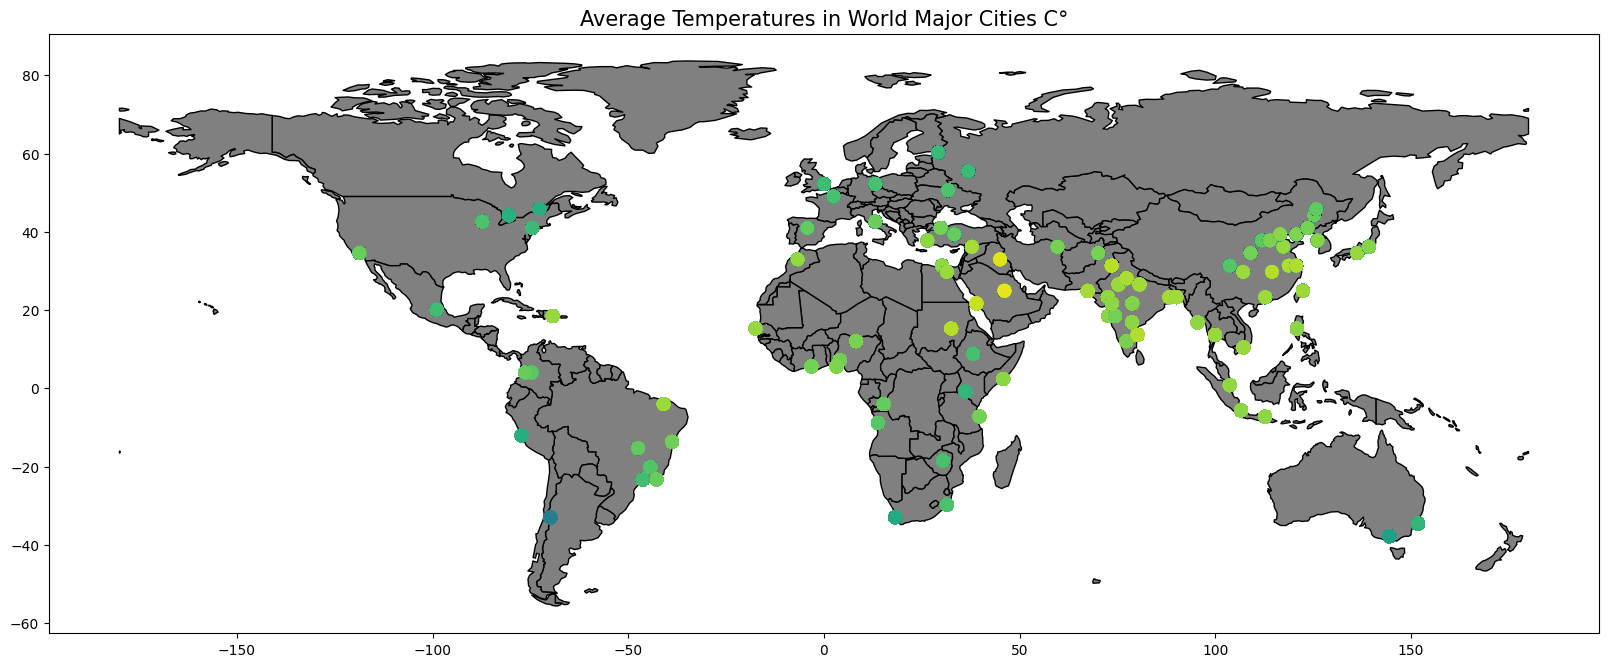

In [7]:
# call the method create_map
my_map.create_map()

The method **create_map_date** add a functionality to the previous function: it allows to choose a date in the dataset, so that you can see the average temperature in that specific day, with a legend:

In [8]:
def create_map_date(self, date):
    filtered_ds = self.ds[self.ds['dt'] == date]
    if not filtered_ds.empty:
        self.create_map(filtered_ds, self.dw, True)
    else:
        print('Data not available for the given date.')

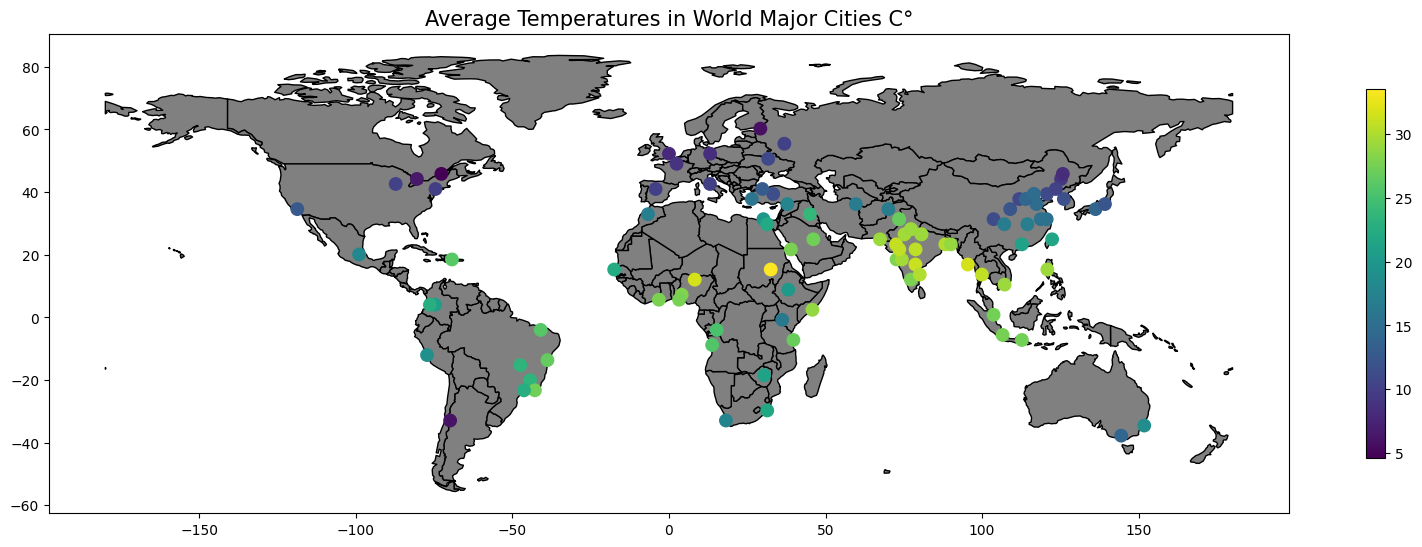

Map of 2001-04-01


In [9]:
my_map.create_map_date('2001-04-01')

The method **create_map_gif** creates a gif with the maps of the average temperatures, taking the dates from a given list of dates.

In [10]:
def create_map_gif(self, dates):
    fig, ax = plt.subplots(figsize=(20, 16))
    axis = self.dw.plot(ax=ax, color='grey', edgecolor='black')
    dates.sort()
    def update(frame):
        current_date = dates[frame]
        filtered_cities = self.ds[self.ds['dt'] == current_date]
        scatter = filtered_cities.plot(column='AverageTemperature', ax=axis, markersize=80)
        plt.title(f'Average Temperatures in World Major Cities C° ({current_date})', fontsize=25)
        return scatter

    def init():
        # create an empty colour with the appropriate colormap and normalization
        sm = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=-40, vmax=40))
        sm.set_array([]) # empty array for the data range
        # add the colour to the figure
        cbar = plt.colorbar(sm, ax=ax, fraction=0.02, pad=0.04)
        cbar.ax.tick_params(labelsize=14)
        return cbar

    animation = FuncAnimation(fig, update, frames=len(dates), interval=250, init_func=init)
    animation.save('temperature_animation.gif', fps=1) # save the gif

MovieWriter ffmpeg unavailable; using Pillow instead.


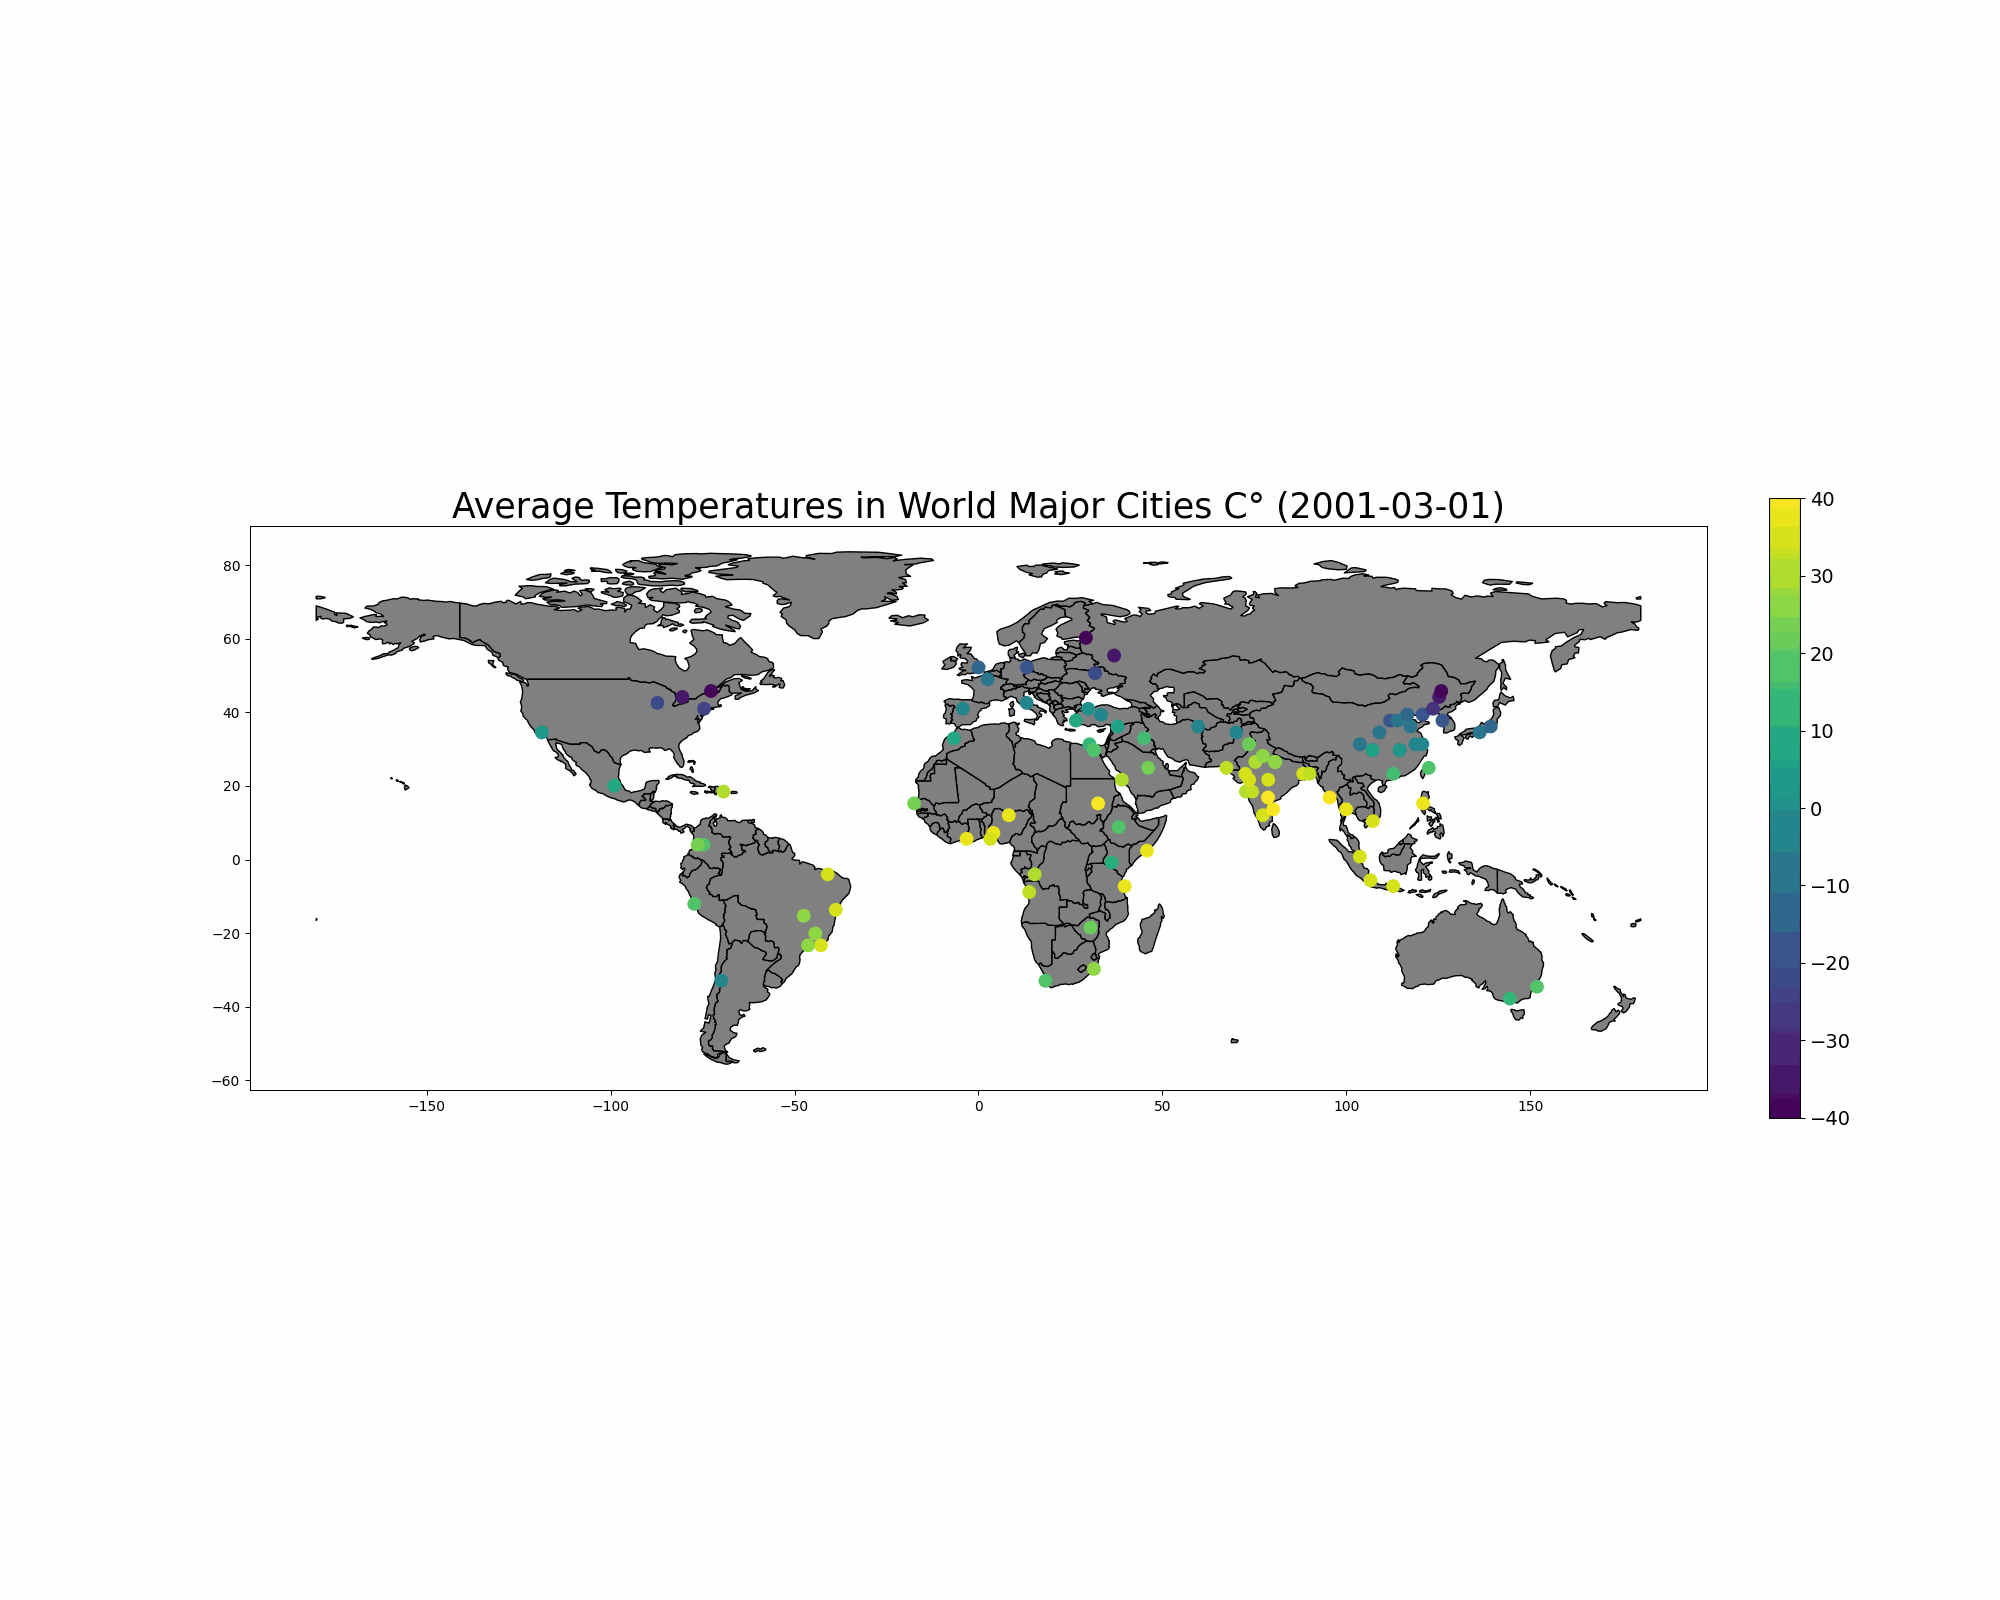

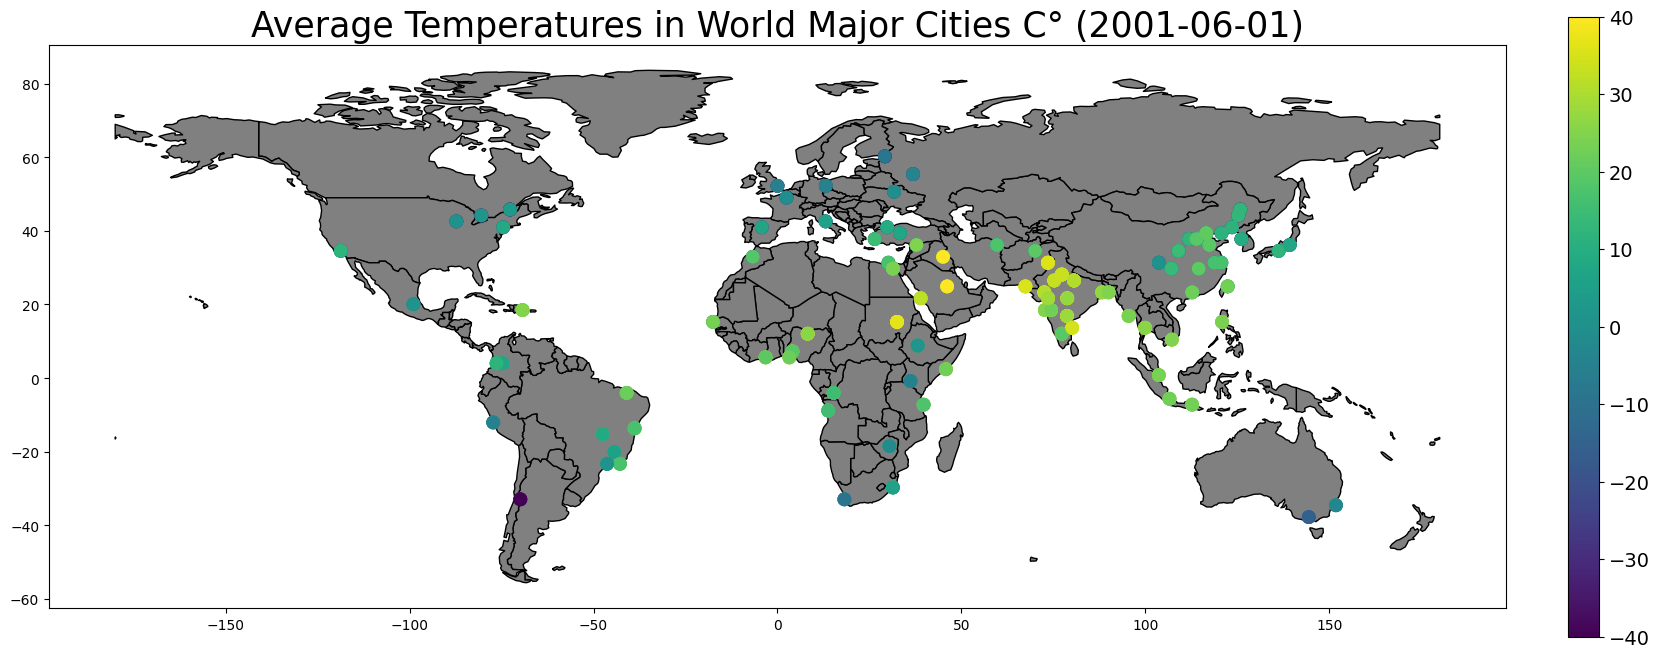

In [11]:
from IPython.display import display, Image
my_map2 = Map(gpd_cities, gpd_world)
dates = ['2001-04-01', '2001-03-01', '2001-05-01', '2001-06-01']
my_map2.create_map_gif(dates)
with open('temperature_animation_dates.gif', 'rb') as f:
    display(Image(data=f.read(), format='png'))

The method **date_map_gif** has the same concept, but allow to choose a range of dates:

In [12]:
    def date_map_gif(self, min_date, max_date):
        panda_dates = self.ds[(self.ds['dt'] >= min_date) & (self.ds['dt'] <= max_date)]
        dates = panda_dates['dt'].tolist()
        self.create_map_gif(dates)

MovieWriter ffmpeg unavailable; using Pillow instead.


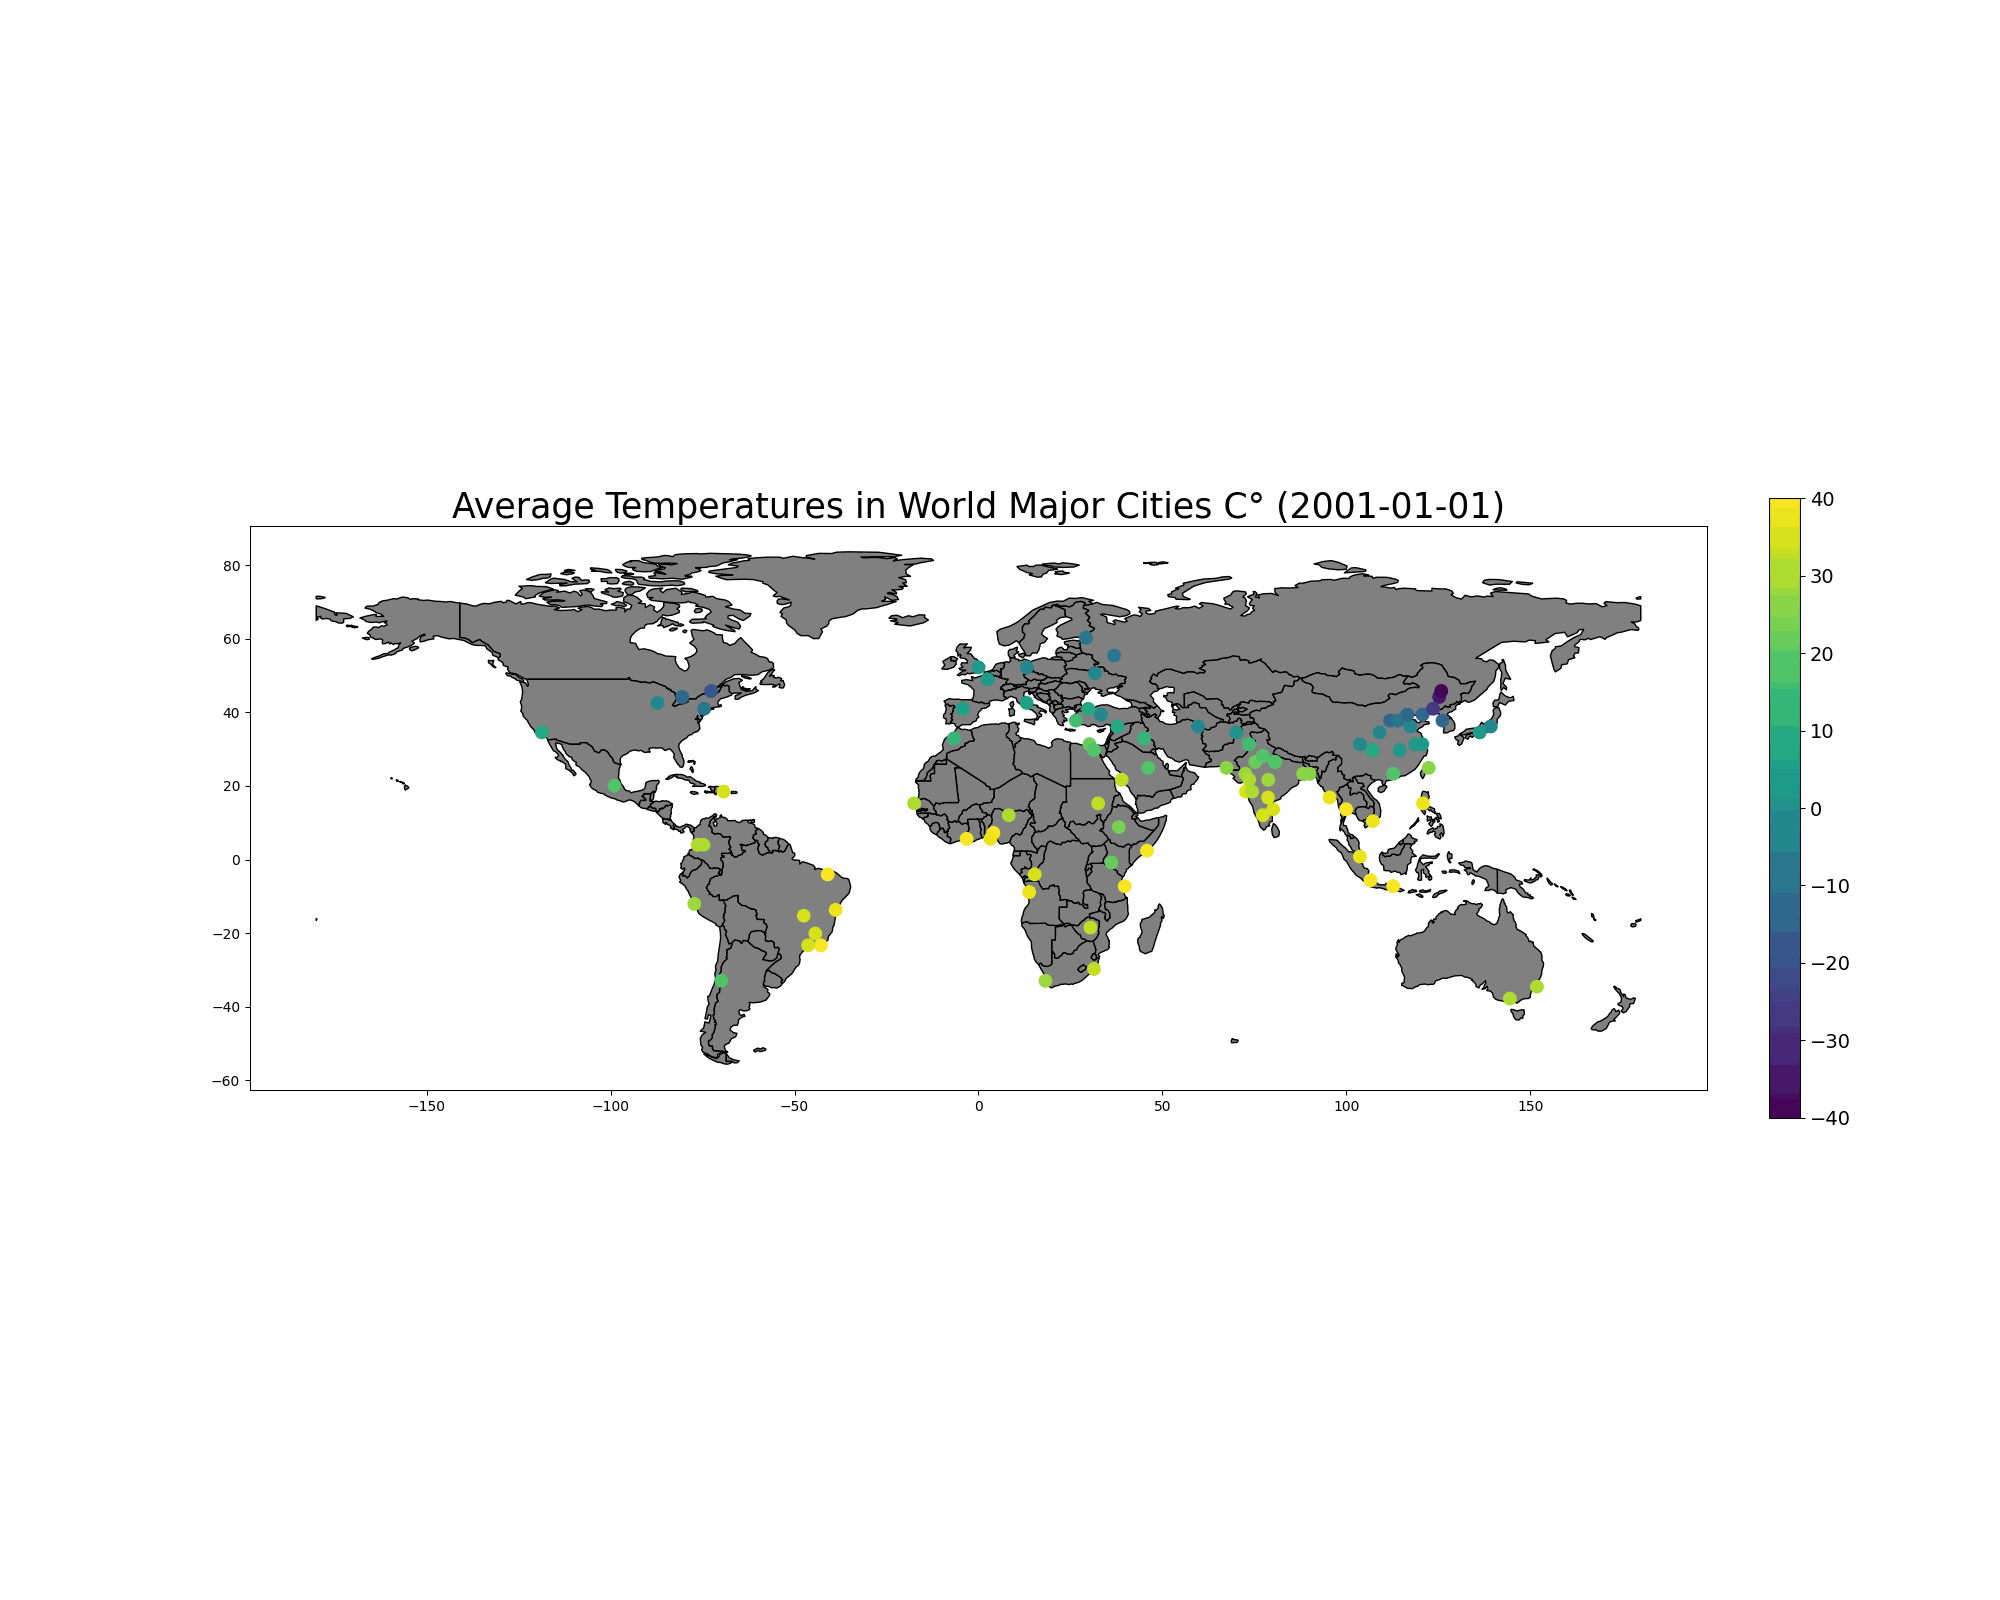

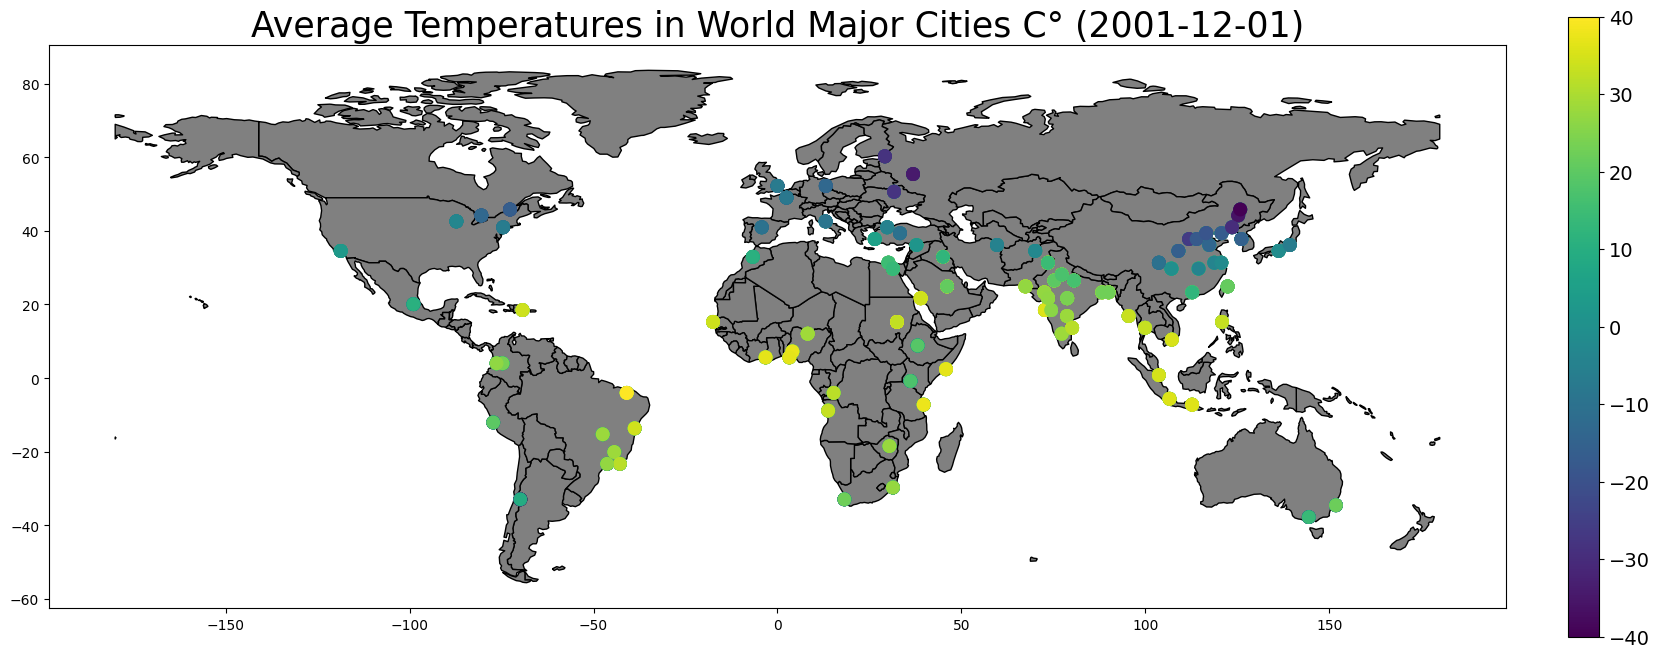

In [13]:
my_map3 = Map(gpd_cities, gpd_world)
min_date = '2001-01-01'
max_date = '2001-12-01'
my_map3.date_map_gif(min_date, max_date)

with open('temperature_animation_dates2.gif', 'rb') as f:
    display(Image(data=f.read(), format='png'))

The function **create_map_range** creates a map that shows the top 5 cities per temperature range between two dates.

In [14]:
    def create_map_range(self, start_date, end_date):
        # filter data within the specified date range
        filtered_data = self.ds[(self.ds['dt'] >= start_date) & (self.ds['dt'] <= end_date)]
        # calculate temperature range for each city within the specified date range
        city_temperature_ranges = filtered_data.groupby('City')['AverageTemperature'].agg(['min', 'max']).apply(
            lambda x: (x['min'], x['max']), axis=1)
        # get top 5 cities with the highest temperature difference within the specified date range
        top_cities = city_temperature_ranges.apply(lambda x: x[1] - x[0]).nlargest(5).index
        # filter data for top 5 cities within the specified date range
        top_cities_data = filtered_data[filtered_data['City'].isin(top_cities)]

        # create a world map
        axis = self.dw.plot(color='grey', edgecolor='black')
        # plot top 5 cities with the highest temperature range within the specified date range
        top_cities_data.plot(column='AverageTemperature', ax=axis, markersize=80)

        # annotate the map with city names and temperature ranges
        i = -80
        for idx, (city, (min_temp, max_temp)) in enumerate(city_temperature_ranges[top_cities].items()):
            plt.text(0, i, f'{city}: {round(min_temp, 1)}°C to {round(max_temp, 1)}°C: {round(max_temp - min_temp, 1)}C°',
                     fontsize=24, horizontalalignment='center')
            i = i - 9
        plt.title('Top 5 Cities with Highest Temperature Range\n{} to {}'.format(start_date, end_date), fontsize=15)
        fig = plt.gcf()
        fig.set_size_inches(20, 16)
        plt.show()

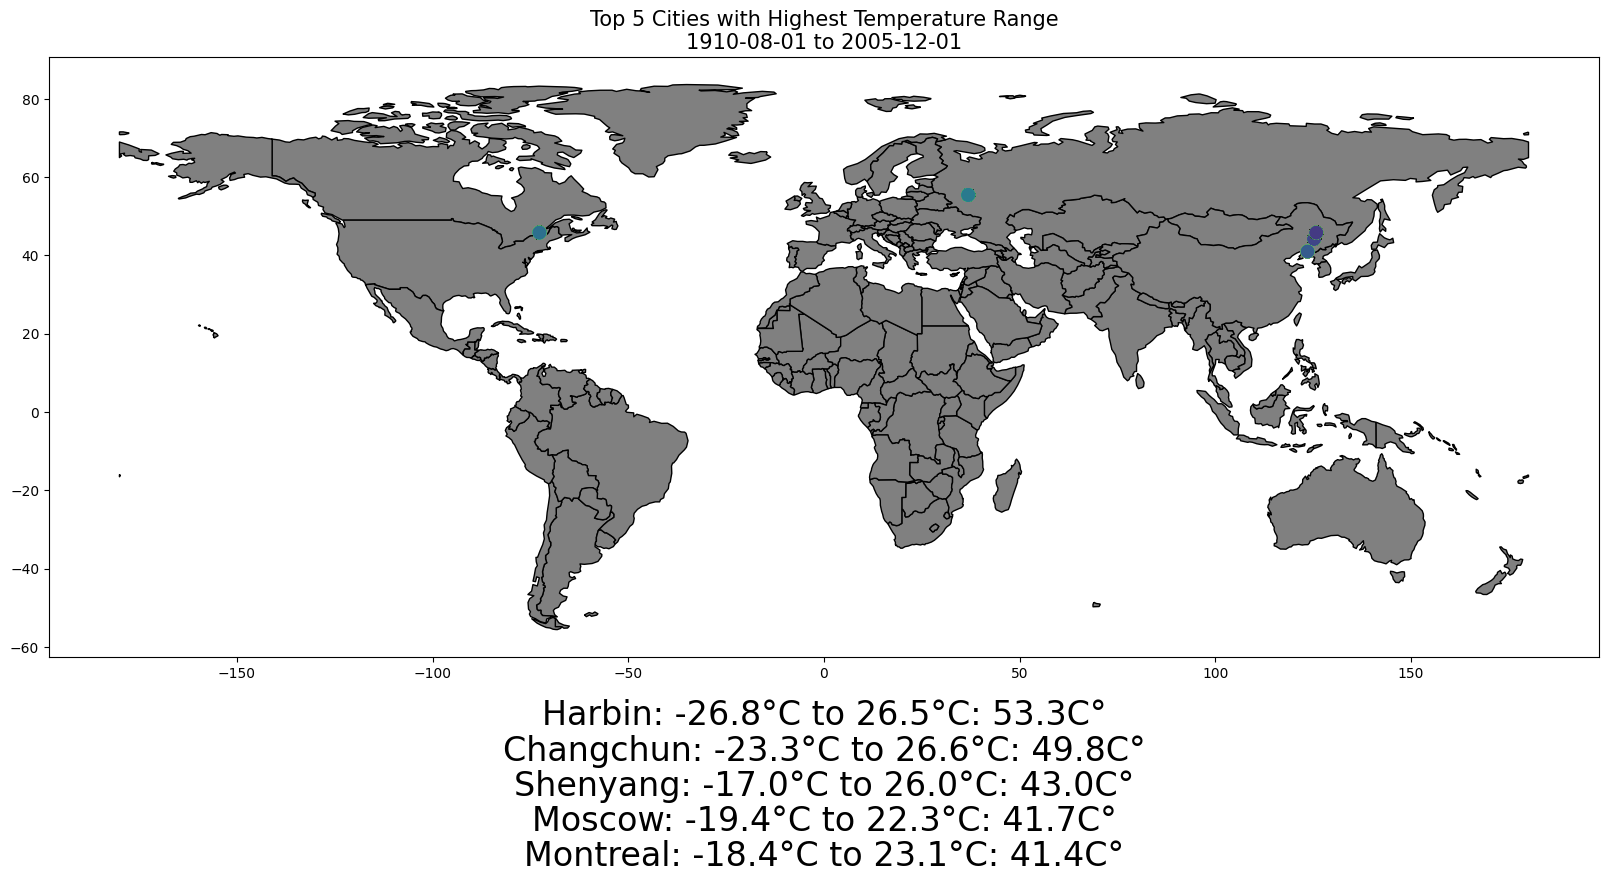

In [15]:
my_map4 = Map(gpd_cities, gpd_world)
my_map4.create_map_range('1910-08-01', '2005-12-01')

For the last task I created three functions:
- **calculate_distance**: computes the distance between two cities;
- **warmest_closest_city**: returns the warmest city between the 5 closest ones;
- **best_route**: the final one, return a list with the path that links the two given cities.

In [16]:
def calculate_distance(city1, city2, route):
    # calculate the distance between two cities using their latitude and longitude coordinates
    lat1, lon1 = city1['Latitude'], city1['Longitude']
    lat2, lon2 = city2['Latitude'], city2['Longitude']

    # Haversine formula to compute distances on the Earth's surface in kms
    radius = 6371  # earth radius in kilometers
    dlat = math.radians(lat2 - lat1)
    dlon = math.radians(lon2 - lon1)
    a = math.sin(dlat / 2) ** 2 + math.cos(math.radians(lat1)) * math.cos(math.radians(lat2)) * math.sin(dlon / 2) ** 2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    distance = radius * c

    if city1['City'] in route:   # I set the cities where we already have been and the current city out of the planet to avoid loops :)
        return 1000000000
    else:
        return distance


def warmest_closest_city(current_city, ds, route):
    cities = []
    for idx, city in ds.iterrows():
        distance = calculate_distance(city, current_city, route)
        cities.append((distance, city))

    top5 = sorted(cities, key=lambda x: x[0])[:5]    # one line function to take the top 5 cities by distance (closest)
    warmest = max(top5, key=lambda x: x[1]['AverageTemperature'])   # same but by AverageTemperature

    return warmest[1].loc['City']        # we return the name of the warmest city


def best_route(ds, date, start_city, target_city):
    ds = ds[ds['dt'] == date]
    route = [start_city]
    current_city = start_city  # initialize current_city with the start city name

    while current_city != target_city:
        # find the GeoDataFrame row for the current city
        current_city_row = ds[ds['City'] == current_city].iloc[0]
        warmest = warmest_closest_city(current_city_row, ds, route)
        # extract the city name from the GeoDataFrame row
        current_city = warmest
        route.append(current_city)
    return route

Then I created the method **best_route_obj** that call the function:

In [17]:
my_map5 = Map(gpd_cities, gpd_world)
path = my_map5.best_route_obj('2001-04-01', 'Peking', 'Los Angeles')

for index, element in enumerate(path):
    print(f"{index}. {element}")

0. Peking
1. Tianjin
2. Jinan
3. Shanghai
4. Taipei
5. Manila
6. Ho Chi Minh City
7. Rangoon
8. Hyderabad
9. Nagpur
10. Surat
11. Ahmadabad
12. Jaipur
13. Kanpur
14. Calcutta
15. Madras
16. Pune
17. Lakhnau
18. Delhi
19. Karachi
20. New Delhi
21. Dhaka
22. Bangkok
23. Jakarta
24. Bangalore
25. Bombay
26. Riyadh
27. Jiddah
28. Umm Durman
29. Cairo
30. Gizeh
31. Alexandria
32. Baghdad
33. Aleppo
34. Mashhad
35. Faisalabad
36. Lahore
37. Chongqing
38. Guangzhou
39. Wuhan
40. Nanjing
41. Tangshan
42. Xian
43. Seoul
44. Nagoya
45. Tokyo
46. Dalian
47. Chengdu
48. Kabul
49. Istanbul
50. Izmir
51. Ankara
52. Kiev
53. Moscow
54. Rome
55. Casablanca
56. Dakar
57. Kano
58. Ibadan
59. Abidjan
60. Lagos
61. Luanda
62. Dar Es Salaam
63. Mogadishu
64. Kinshasa
65. Durban
66. Rio De Janeiro
67. Salvador
68. Fortaleza
69. Santo Domingo
70. Cali
71. Brasília
72. Belo Horizonte
73. São Paulo
74. Bogotá
75. Lima
76. Mexico
77. Los Angeles


The method **avg_temperature_graph** plot the average temperature of the given month through the years and save it as a png file. 

In [18]:
import calendar
    
def avg_temperature_graph(self, city, month):
    self.ds['dt'] = pd.to_datetime(self.ds['dt'])
    filtered_ds = self.ds[(self.ds['City'] == city) & (self.ds['dt'].dt.month == month)]
    # get the month name using the calendar module
    month = calendar.month_name[month]
    # plotting
    plt.figure(figsize=(10, 6))
    plt.plot(filtered_ds['dt'], filtered_ds['AverageTemperature'], color='red')
    plt.title(f'Average Temperature (C°) in {city} for {month}- from {filtered_ds["dt"].dt.year.min()} to {filtered_ds["dt"].dt.year.max()}', fontsize=15)
    plt.xlabel('Year')
    plt.ylabel('Average Temperature')
    plt.grid(True)
    plt.show()
        
    

In [ ]:
my_map6 = Map(gpd_cities, gpd_world)
my_map.avg_temperature_graph('Peking', 11)

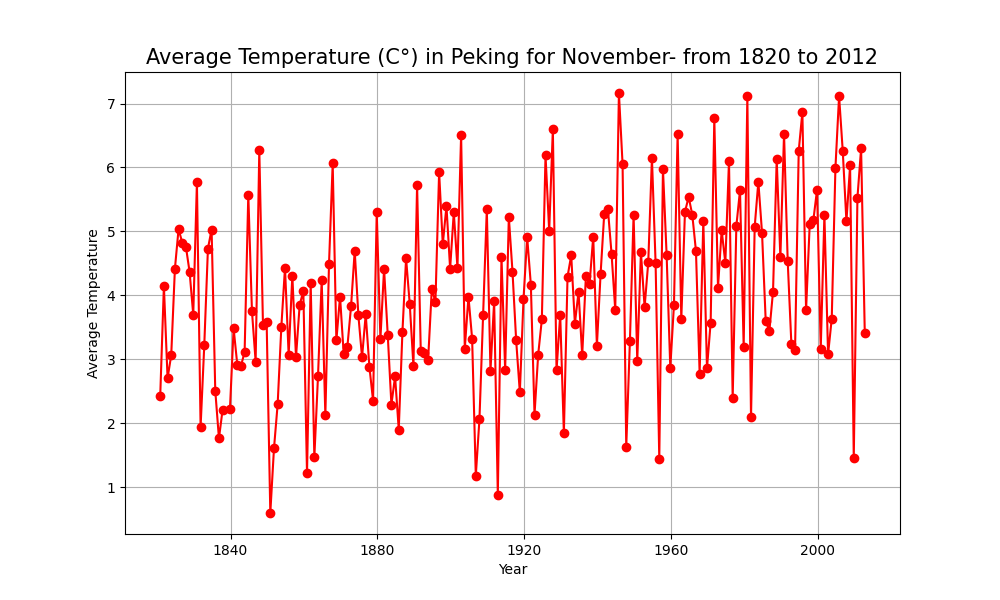

In [21]:
with open('average_temperature_years.png', 'rb') as f:
    display(Image(data=f.read(), format='png'))